In [105]:
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.graphics.gofplots import qqplot
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.impute import SimpleImputer
# SimpleImputer does not have get_feature_names_out, so we need to add it manually.
SimpleImputer.get_feature_names_out = (lambda self, names = None: self.feature_names_in_)
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import cross_val_score, cross_validate, learning_curve, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn import set_config; set_config(display='diagram')

from sklearn.metrics import mean_squared_error, make_scorer
import sklearn.metrics as metrics

from xgboost import XGBRegressor
from sklearn_evaluation import plot

from housing_crawler.analysis.ads_table_processing import get_processed_ads_table
from housing_crawler.utils import return_significative_coef

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
# sklearndf is an sklearn alternative that returns dataframes from transformers instead of np.arrays
# https://github.com/BCG-Gamma/sklearndf
from sklearndf.transformation import ColumnTransformerDF,OneHotEncoderDF,SimpleImputerDF,StandardScalerDF,RobustScalerDF,MinMaxScalerDF
from sklearndf.pipeline import PipelineDF

# Prepare data

## Obtain data for WGs

In [107]:
df_original = get_processed_ads_table()


===> Loaded all_encoded.csv locally
===> ads_OSM.csv saved locally


In [108]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27890 entries, 0 to 27900
Columns: 146 entries, id to cos_day_week_int
dtypes: Float64(2), Int64(1), datetime64[ns](3), float64(117), int64(5), object(18)
memory usage: 31.4+ MB


In [109]:
ads_feat_df = df_original[df_original['details_searched']==1]
# ads_feat_df = ads_feat_df[ads_feat_df['city'].isin(['Berlin'])]#, 'München', 'Hamburg', 'Stuttgart', 'Köln', 'Münster', 'Leipzig', 'Frankfurt am Main'])]
ads_feat_df = ads_feat_df.set_index('id')

## Remove duplicates if exist

In [110]:
# Number of duplicate data points
# It's very likely zero cause I already removed dulicated IDs during processing
ads_feat_df.duplicated().sum()

0

## Filter data accordingly

In [111]:
# Filter only ads that have been searched for details (search added from august on)
df_filtered = ads_feat_df.copy()
df_filtered = df_filtered[df_filtered['type_offer_simple']=='WG']
df_filtered = df_filtered[df_filtered['km_to_centroid'].notna()]
df_filtered = df_filtered.drop(columns=['details_searched','type_offer_simple'])
df_filtered.describe()

,commercial_landlord,price_euros,size_sqm,available_rooms,capacity,available_spots_wg,male_flatmates,female_flatmates,diverse_flatmates,published_at,latitude,longitude,cold_rent_euros,mandatory_costs_euros,extra_costs_euros,transfer_costs_euros,deposit,zip_code,wg_possible,building_floor,public_transport_distance,home_total_size,schufa_needed,min_age_flatmates,max_age_flatmates,min_age_searched,max_age_searched,construction_year,energy_usage,energy_efficiency_class,price_per_sqm_warm,price_per_sqm_cold,number_languages,internet_speed,toilet,internet_dsl,internet_wlan,internet_flatrate,shower_type_badewanne,shower_type_dusche,floor_type_dielen,floor_type_parkett,floor_type_laminat,floor_type_teppich,floor_type_fliesen,floor_type_pvc,floor_type_fußbodenheizung,extras_waschmaschine,extras_spuelmaschine,extras_terrasse,extras_balkon,extras_garten,extras_gartenmitbenutzung,extras_keller,extras_aufzug,extras_haustiere,extras_fahrradkeller,extras_dachboden,languages_deutsch,languages_englisch,wg_type_studenten,wg_type_keine_zweck,wg_type_maenner,wg_type_business,wg_type_wohnheim,wg_type_vegetarisch_vegan,wg_type_alleinerziehende,wg_type_funktionale,wg_type_berufstaetigen,wg_type_gemischte,wg_type_mit_kindern,wg_type_verbindung,wg_type_lgbtqia,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugruendung,tv_kabel,tv_satellit,days_available,furniture_numerical,kitchen_numerical,smoking_numerical,room_size_house_fraction,flat_with_kids,km_to_centroid,comfort_leisure_spots,comfort_warehouse,activities_education,mobility_public_transport_bus,activities_economic,comfort_industrial,activities_goverment,social_life_eating,comfort_comfort_spots,social_life_culture,activities_supermarket,activities_public_service,social_life_community,comfort_leisure_mass,activities_educational,mobility_street_secondary,mobility_public_transport_rail,activities_retail,social_life_night_life,comfort_green_natural,comfort_railway,mobility_bike_infraestructure,comfort_green_forests,mobility_street_primary,comfort_lakes,activities_health_regional,activities_health_local,comfort_green_space,comfort_rivers,activities_post,comfort_green_parks,comfort_street_motorway,sin_degrees_to_centroid,cos_degrees_to_centroid,sin_published_at,cos_published_at,sin_day_week_int,cos_day_week_int
count,8405.000000,8405.000000,8405.000000,8405.0,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,6747.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8392.000000,8405.0,7491.000000,7390.000000,5803.000000,8405.000000,6335.000000,5931.000000,8405.000000,8405.000000,942.000000,295.000000,431.000000,8405.000000,8405.000000,8405.000000,2535.000000,17.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,5803.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8.405000e+03,8405.000000,8405.000000,8405.000000,8.405000e+03,8405.0,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.0,8405.000000,8405.000000,8405.0,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,6.747000e+03,6747.000000,8405.000000,8405.000000
mean,0.007971,480.749911,17.301606,1.0,3.267103,1.256038,0.959548,1.034622,0.016895,14.989477,50.926286,10.207643,386.692802,58.731350,6.761214,30.497918,568.462582,44977.895853,1.0,1.992591,3.200541,92.109426,0.085425,24.404420,29.949756,13.640333,58.759310,1945.1836

## Drop columns I won't use for modelling

In [112]:
# Drop unnecessary columns
df_filtered = df_filtered[[
#         'url',
        'commercial_landlord',
#         'title',
#         'type_offer_simple',
#         'size_sqm',
        'home_total_size',
        'room_size_house_fraction',
#         'available_rooms',
        'capacity',
#         'available_spots_wg',
    
#         'address',
        'city',
#         'zip_code',
#         'latitude',
#         'longitude',
    
#         'published_on',
#         'published_at',
#         'day_of_week_publication',
#         'available_from',
#         'available_to',
#         'days_available',
        'rental_length_term', # use rental length period cause relationship isnt linear. Correlates for first 30 days only
#         'sin_published_at',
#         'cos_published_at',
#         'sin_day_week_int',
#         'cos_day_week_int',
    
#         'details_searched',
#         'crawler',
    
# Values
#         'price_euros',    
#         'cold_rent_euros',
#         'mandatory_costs_euros',
#         'extra_costs_euros',
#         'deposit',
        'transfer_costs_euros',
#         'price_per_sqm_warm',
        'price_per_sqm_cold',

# Flatmates
        'male_flatmates',
        'female_flatmates',
        'diverse_flatmates',
        'min_age_flatmates',
        'max_age_flatmates',
        'flat_with_kids',
    
# Person searched
        'gender_searched',
        'min_age_searched',
        'max_age_searched',
#         'age_category_searched',
    
# Details
    
        'schufa_needed',
#         'wg_possible',
    
#         'smoking',
        'smoking_numerical',
        'building_type',
        'building_floor',
#         'furniture',
        'furniture_numerical',
#         'kitchen',
        'kitchen_numerical',
        'heating',
        'public_transport_distance',
        'parking',
    
#         'construction_year',
#         'energy_certificate',
#         'energy_usage',
#         'energy_efficiency_class',
#         'heating_energy_source',
    
        'tv_kabel',
        'tv_satellit',
    
#         'toilet',
        'shower_type_badewanne',
        'shower_type_dusche',
    
        'floor_type_dielen',
        'floor_type_parkett',
        'floor_type_laminat',
        'floor_type_teppich',
        'floor_type_fliesen',
        'floor_type_pvc',
        'floor_type_fußbodenheizung',
    
        'extras_waschmaschine',
        'extras_spuelmaschine',
        'extras_terrasse',
        'extras_balkon',
        'extras_garten',
        'extras_gartenmitbenutzung',
        'extras_keller',
        'extras_aufzug',
        'extras_haustiere',
        'extras_fahrradkeller',
        'extras_dachboden',
    
# WG only
        'number_languages',
        'languages_deutsch',
        'languages_englisch',
    
        'wg_type_studenten',
        'wg_type_keine_zweck',
        'wg_type_maenner',
        'wg_type_business',
        'wg_type_wohnheim',
        'wg_type_vegetarisch_vegan',
        'wg_type_alleinerziehende',
        'wg_type_funktionale',
        'wg_type_berufstaetigen',
        'wg_type_gemischte',
        'wg_type_mit_kindern',
        'wg_type_verbindung',
        'wg_type_lgbtqia',
        'wg_type_senioren',
        'wg_type_inklusive',
        'wg_type_wg_neugruendung',
    
        'internet_speed',
        'internet_dsl',
        'internet_wlan',
        'internet_flatrate',
    

# Geographical
        'km_to_centroid',
        'sin_degrees_to_centroid',
        'cos_degrees_to_centroid',

# OSM features
        'comfort_leisure_spots',
        'comfort_warehouse',
        'activities_education',
        'mobility_public_transport_bus',
        'activities_economic',
        'comfort_industrial',
        'activities_goverment',
        'social_life_eating',
        'comfort_comfort_spots',
        'social_life_culture',
        'activities_supermarket',
#         'activities_public_service',
        'social_life_community',
        'comfort_leisure_mass',
        'activities_educational',
        'mobility_street_secondary',
        'mobility_public_transport_rail',
        'activities_retail',
        'social_life_night_life',
        'comfort_green_natural',
        'comfort_railway',
        'mobility_bike_infraestructure',
#         'comfort_green_forests',
        'mobility_street_primary',
        'comfort_lakes',
#         'activities_health_regional',
        'activities_health_local',
        'comfort_green_space',
        'comfort_rivers',
        'activities_post',
        'comfort_green_parks',
        'comfort_street_motorway'
        ]]

In [113]:
df_filtered.shape

(8405, 103)

# Removing outliers

In [114]:
### List of columns with manually inserted values that would possibly contain outliers and/werid values

manually_inserted_values_columns = [
#     'price_euros',
#     'size_sqm',
#     'cold_rent_euros',
#     'price_per_sqm_warm',
    'price_per_sqm_cold',
#     'mandatory_costs_euros',
#     'extra_costs_euros',
#     'deposit',
    'home_total_size',
    'room_size_house_fraction',
    'public_transport_distance',
    'transfer_costs_euros',
    'min_age_flatmates',
    'max_age_flatmates',
    'min_age_searched',
    'max_age_searched',
#     'construction_year',
#     'energy_usage'
]

'room_size_house_fraction'

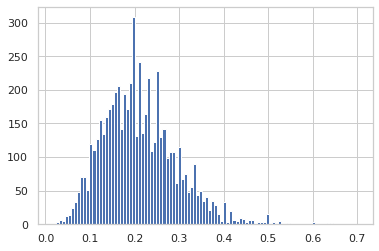

In [115]:
### Manually look into the variable distribution to identify outliers
col = manually_inserted_values_columns[2]
df_filtered[col].hist(bins = 100);
# df_filtered[[col]].boxplot()
# plt.xlim(0,1000)
# plt.ylim(0,100);
col

# Preprocessing pipeline

In [116]:
X = df_filtered.drop(columns='price_per_sqm_cold')
y = df_filtered[['price_per_sqm_cold']].reset_index()

## Select columns per pipeline

In [117]:
features_OSM = [
                'comfort_leisure_spots',
                'comfort_warehouse',
                'activities_education',
                'mobility_public_transport_bus',
                'activities_economic',
                'comfort_industrial',
                'activities_goverment',
                'social_life_eating',
                'comfort_comfort_spots',
                'social_life_culture',
                'activities_supermarket',
#                 'activities_public_service',
                'social_life_community',
                'comfort_leisure_mass',
                'activities_educational',
                'mobility_street_secondary',
                'mobility_public_transport_rail',
                'activities_retail',
                'social_life_night_life',
                'comfort_green_natural',
                'comfort_railway',
                'mobility_bike_infraestructure',
#                 'comfort_green_forests',
                'mobility_street_primary',
                'comfort_lakes',
#                 'activities_health_regional',
                'activities_health_local',
                'comfort_green_space',
                'comfort_rivers',
                'activities_post',
                'comfort_green_parks',
                'comfort_street_motorway']

In [118]:
# Leave no remainder columns. All columns should be included in one category below

cols_SimpImpMean_StandardScaler = ['km_to_centroid']
cols_SimpImpMean_MinMaxScaler = ['min_age_flatmates', 'max_age_flatmates', 'min_age_searched', 'max_age_searched',
                                 'public_transport_distance','internet_speed',
                                 'sin_degrees_to_centroid', 'cos_degrees_to_centroid'] + features_OSM
cols_SimpImpMean_RobustScaler = ['home_total_size','room_size_house_fraction']
cols_SimpImpMedian_StandardScaler = [] 
cols_SimpImpMedian_MinMaxScaler = ['commercial_landlord','capacity',
                                   'male_flatmates', 'female_flatmates', 'diverse_flatmates','flat_with_kids',
                                   'schufa_needed','smoking_numerical', 'building_floor', 'furniture_numerical', 'kitchen_numerical',
                                   
                                   'tv_kabel','tv_satellit','shower_type_badewanne','shower_type_dusche',
                                   
                                   'floor_type_dielen','floor_type_parkett','floor_type_laminat','floor_type_teppich',
                                   'floor_type_fliesen','floor_type_pvc','floor_type_fußbodenheizung',
                                   
                                   'extras_waschmaschine','extras_spuelmaschine','extras_terrasse','extras_balkon',
                                   'extras_garten','extras_gartenmitbenutzung','extras_keller','extras_aufzug',
                                   'extras_haustiere','extras_fahrradkeller','extras_dachboden',
                                   
                                   'number_languages','languages_deutsch','languages_englisch',
                                   
                                   'wg_type_studenten','wg_type_keine_zweck','wg_type_maenner','wg_type_business',
                                   'wg_type_wohnheim','wg_type_vegetarisch_vegan','wg_type_alleinerziehende','wg_type_funktionale',
                                   'wg_type_berufstaetigen','wg_type_gemischte','wg_type_mit_kindern','wg_type_verbindung',
                                   'wg_type_lgbtqia','wg_type_senioren','wg_type_inklusive','wg_type_wg_neugruendung',
                                   
                                   'internet_dsl','internet_wlan','internet_flatrate'
                                  ] 
cols_SimpImpMedian_RobustScaler = []
cols_SimpImpConst0_MinMaxScaler = ['transfer_costs_euros']
cols_SimpImpConstNoAns_OHE = ['city','rental_length_term','gender_searched','building_type','heating', 'parking'] 

len(set(cols_SimpImpMean_StandardScaler+cols_SimpImpMean_MinMaxScaler+cols_SimpImpMean_RobustScaler+cols_SimpImpMedian_StandardScaler\
   +cols_SimpImpMedian_MinMaxScaler+cols_SimpImpMedian_RobustScaler+cols_SimpImpConst0_MinMaxScaler+cols_SimpImpConstNoAns_OHE))

102

## Build the imputter/scaler pairs

In [119]:
SimpImpMean_StandardScaler = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="mean")),
    ('StandardScaler', StandardScaler())
])

SimpImpMean_MinMaxScaler = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="mean")),
    ('MinMaxScaler', MinMaxScaler())
])

SimpImpMean_RobustScaler = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="mean")),
    ('RobustScaler', RobustScaler())
])

# SimpImpMedian_StandardScaler = Pipeline([
#     ('SimpleImputer', SimpleImputer(strategy="median")),
#     ('StandardScaler', StandardScaler())
# ])

SimpImpMedian_MinMaxScaler = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="median")),
    ('MinMaxScaler', MinMaxScaler())
])

# SimpImpMedian_RobustScaler = Pipeline([
#     ('SimpleImputer', SimpleImputer(strategy="median")),
#     ('RobustScaler', RobustScaler())
# ])

SimpImpConst0_MinMaxScaler = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="constant", fill_value=0)),
    ('MinMaxScaler', MinMaxScaler())
])

SimpImpConstNoAns_OHE = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="constant", fill_value='no_answer')),
    ('OHE', OneHotEncoder(sparse=False, drop='if_binary', categories='auto'))
])

## Build column transformer pipeline

In [120]:
preprocessor_transformer = ColumnTransformer([
    ('pipeline-1', SimpImpMean_StandardScaler, cols_SimpImpMean_StandardScaler),
    ('pipeline-2', SimpImpMean_MinMaxScaler, cols_SimpImpMean_MinMaxScaler),
    ('pipeline-3', SimpImpMean_RobustScaler, cols_SimpImpMean_RobustScaler),
    ('pipeline-4', SimpImpMedian_MinMaxScaler, cols_SimpImpMedian_MinMaxScaler),
    ('pipeline-5', SimpImpConst0_MinMaxScaler, cols_SimpImpConst0_MinMaxScaler),
    ('pipeline-6', SimpImpConstNoAns_OHE, cols_SimpImpConstNoAns_OHE)
     ],
    remainder='drop')
preprocessor_transformer

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer()),
                                                 ('StandardScaler',
                                                  StandardScaler())]),
                                 ['km_to_centroid']),
                                ('pipeline-2',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer()),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler())]),
                                 ['min_age_flatmates', 'max_age_flatmates',
                                  'min_age_searched', 'max_age_searched',
                                  'public_transport_d...
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler())]),
                                 ['transfer_costs_euros']),
                                ('pipeline-6',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer(fill_value='no_answer',
                                                                strategy='constant')),
                                                 ('OHE',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 ['city', 'rental_length_term',
                                  'gender_searched', 'building_type', 'heating',
                                  'parking'])])

## Create df_processed for further analysis of feature relevance

In [121]:
# Get transformed table with corresponding column names
df_processed = pd.DataFrame(
                            preprocessor_transformer.fit_transform(X), 
                            columns=preprocessor_transformer.get_feature_names_out()
                            )

# Remove the prefix from the column names
df_processed.columns = [col.split('__')[1].lower().replace('ü','ue').replace('ä','ae').replace('ö','oe').replace('-wg','').replace(' wg','').replace('wg ','')\
        .replace(' ','_').replace('/','_').replace('-','_').replace('+','') for col in df_processed.columns]

# Merge target back
df_processed=pd.concat([y,df_processed],axis=1).set_index(keys='id')
                          
df_processed.describe()

,price_per_sqm_cold,km_to_centroid,min_age_flatmates,max_age_flatmates,min_age_searched,max_age_searched,public_transport_distance,internet_speed,sin_degrees_to_centroid,cos_degrees_to_centroid,comfort_leisure_spots,comfort_warehouse,activities_education,mobility_public_transport_bus,activities_economic,comfort_industrial,activities_goverment,social_life_eating,comfort_comfort_spots,social_life_culture,activities_supermarket,social_life_community,comfort_leisure_mass,activities_educational,mobility_street_secondary,mobility_public_transport_rail,activities_retail,social_life_night_life,comfort_green_natural,comfort_railway,mobility_bike_infraestructure,mobility_street_primary,comfort_lakes,activities_health_local,comfort_green_space,comfort_rivers,activities_post,comfort_green_parks,comfort_street_motorway,home_total_size,room_size_house_fraction,commercial_landlord,capacity,male_flatmates,female_flatmates,diverse_flatmates,flat_with_kids,schufa_needed,smoking_numerical,building_floor,furniture_numerical,kitchen_numerical,tv_kabel,tv_satellit,shower_type_badewanne,shower_type_dusche,floor_type_dielen,floor_type_parkett,floor_type_laminat,floor_type_teppich,floor_type_fliesen,floor_type_pvc,floor_type_fußbodenheizung,extras_waschmaschine,extras_spuelmaschine,extras_terrasse,extras_balkon,extras_garten,extras_gartenmitbenutzung,extras_keller,extras_aufzug,extras_haustiere,extras_fahrradkeller,extras_dachboden,number_languages,languages_deutsch,languages_englisch,wg_type_studenten,wg_type_keine_zweck,wg_type_maenner,wg_type_business,wg_type_wohnheim,wg_type_vegetarisch_vegan,wg_type_alleinerziehende,wg_type_funktionale,wg_type_berufstaetigen,wg_type_gemischte,wg_type_mit_kindern,wg_type_verbindung,wg_type_lgbtqia,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugruendung,internet_dsl,internet_wlan,internet_flatrate,transfer_costs_euros,city_aachen,city_berlin,city_bonn,city_bremen,city_darmstadt,city_dresden,city_frankfurt_am_main,city_goettingen,city_hamburg,city_hannover,city_heidelberg,city_karlsruhe,city_kiel,city_koeln,city_leipzig,city_mainz,city_mannheim,city_muenchen,city_muenster,city_nuernberg,city_regensburg,city_stuttgart,city_tuebingen,city_wuerzburg,rental_length_term_180days,rental_length_term_270days,rental_length_term_30days,rental_length_term_365days,rental_length_term_540days,rental_length_term_90days,rental_length_term_plus540days,gender_searched_divers,gender_searched_egal,gender_searched_frau,gender_searched_mann,building_type_altbau,building_type_doppelhaus,building_type_einfamilienhaus,building_type_hochhaus,building_type_mehrfamilienhaus,building_type_neubau,building_type_plattenbau,building_type_reihenhaus,building_type_no_answer,building_type_sanierter_altbau,heating_fernwaerme,heating_gasheizung,heating_kohleofen,heating_nachtspeicherofen,heating_ofenheizung,heating_zentralheizung,heating_no_answer,parking_bewohnerparken,parking_tiefgaragenstellplatz,parking_eigener_parkplatz,parking_gute_parkmoeglichkeiten,parking_no_answer,parking_schlechte_parkmoeglichkeiten
count,8405.000000,8.405000e+03,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8.405000e+03,8405.000000,8405.000000,8405.000000,8.405000e+03,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8.405000e+03,8.405000e+03,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,8405.000000,

In [122]:
df_processed.shape

(8405, 155)

# Minimize features

In [123]:
df_minimal = df_processed.copy()

In [124]:
df_minimal.shape

(8405, 155)

In [125]:
# Define columns to be tested. Don't test the target, commercial_landlord and 'city'
cols_to_search = [col for col in df_minimal.columns if col not in ['price_per_sqm_cold', 'commercial_landlord']]
cols_to_search = [col for col in cols_to_search if not col.startswith('city_')]

cols_exclude_minimization = []
for col in cols_to_search:
    # How many times the most frequent val exists
    most_freq_count = list(df_minimal[col].value_counts())[0]
    
    if most_freq_count > len(df_minimal)*0.99:
        cols_exclude_minimization.append(col)

        
# Exclude all columns (except cities) with >99% of the same value (0) as it contains very little information
df_minimal = df_minimal.drop(columns=cols_exclude_minimization)
df_minimal.shape

(8405, 142)

In [126]:
cols_exclude_minimization

['kitchen_numerical',
 'extras_dachboden',
 'wg_type_wohnheim',
 'wg_type_alleinerziehende',
 'wg_type_mit_kindern',
 'wg_type_verbindung',
 'wg_type_senioren',
 'wg_type_inklusive',
 'gender_searched_divers',
 'building_type_plattenbau',
 'heating_kohleofen',
 'heating_nachtspeicherofen',
 'heating_ofenheizung']

# Colinearity

In [127]:
df_analysed = df_minimal.copy()

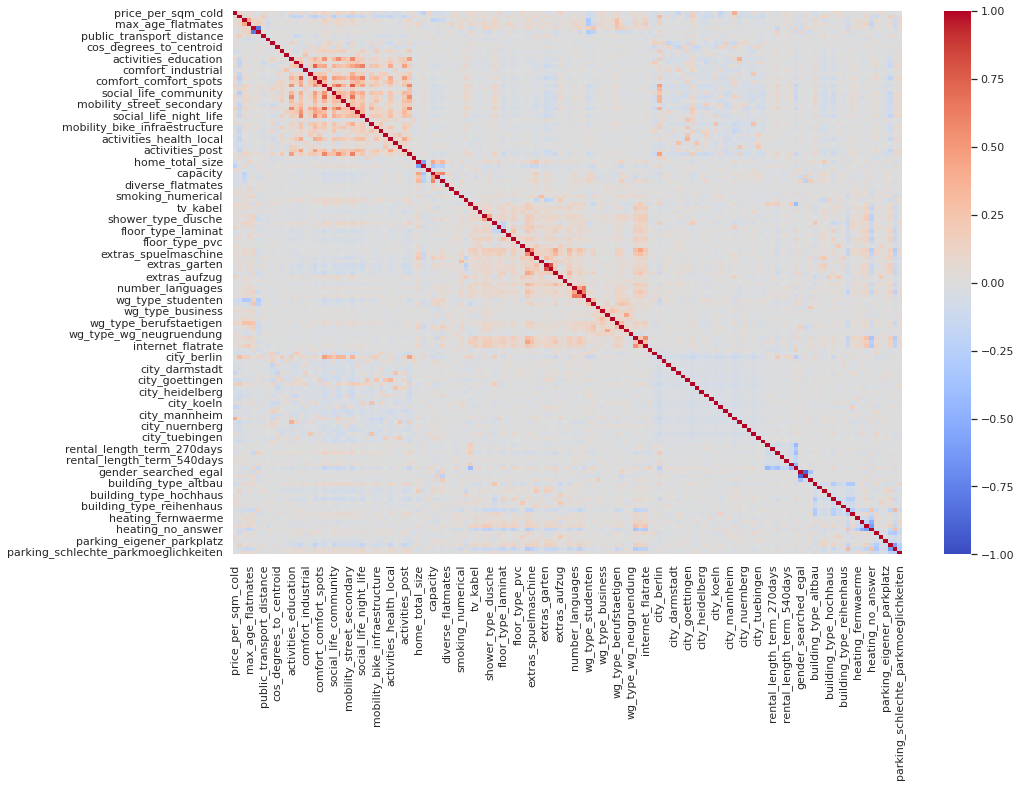

In [128]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

data_corr = df_minimal.corr()
sns.heatmap(data_corr, cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-1, vmax=1);

In [130]:
cols_to_exclude_VIF = [#'age_category_searched_20_100',
                                        'parking_schlechte_parkmoeglichkeiten',
                                        'rental_length_term_plus540days',
                                        'internet_speed',
                                        #'extras_gartenmitbenutzung',
                                        'gender_searched_egal'
                                       ]

df_analysed = df_analysed.drop(columns=cols_to_exclude_VIF)

In [131]:
data_corr = df_analysed.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
# corr_df['correlation'] = -corr_df['correlation'] # Invert signal to see negative correlation
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

,feature_1,feature_2,correlation
9173,extras_gartenmitbenutzung,extras_garten,0.799575
9036,extras_garten,extras_gartenmitbenutzung,0.799575
3330,mobility_public_transport_rail,social_life_culture,0.760904
2508,social_life_culture,mobility_public_transport_rail,0.760904
1810,activities_economic,social_life_eating,0.726737
2221,social_life_eating,activities_economic,0.726737
2505,social_life_culture,comfort_leisure_mass,0.681444
2916,comfort_leisure_mass,social_life_culture,0.681444
2922,comfort_leisure_mass,mobility_public_transport_rail,0.664582
3333,mobility_public_transport_rail,comfort_leisure_mass,0.664582


In [132]:
# These are columns that are always removed, so I'm removing them prematurely to reduce the calculation time
# df_analysed = df_analysed.drop(columns = ['internet_speed',
#                     'max_age_searched',
# #                     'rental_length_term_plus540days',
#                     'days_available',
#                     'min_age_flatmates',
#                     'min_age_searched'
#                   ])

In [ ]:
# Automatized Variation Inflation Factor (VIF) analysis
# Removing columns must be done one at a time because they influence each others VIF results

remove = True
while remove:
    df = pd.DataFrame()
    
    selected_columns = ['price_per_sqm_cold'] # Ignore the targer column
    selected_columns = [col for col in df_analysed.columns.to_list() if col not in selected_columns]

    df["features"] = selected_columns

    df["vif_index"] = [vif(df_analysed[selected_columns].values, i) for i in range(df_analysed[selected_columns].shape[1])]

    df = round(df.sort_values(by="vif_index", ascending = False),2)
    
    df = df.head(1)

    if float(df.vif_index) >= 10:
        print(df)
        cols_to_exclude_VIF = cols_to_exclude_VIF + df.features.to_list()
        df_analysed = df_analysed.drop(columns = df.features)
    else:
        remove = False

cols_to_exclude_VIF

       features  vif_index
88  city_berlin      75.68


In [ ]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()


selected_columns = [col for col in df_analysed.columns.to_list() if col not in ['price_per_sqm_cold']]

df["features"] = selected_columns

df["vif_index"] = [vif(df_analysed[selected_columns].values, i) for i in range(df_analysed[selected_columns].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)[:10]

In [ ]:
df_analysed.info()

# Feature permutation

In [ ]:
df_permuted = df_analysed.copy()

## Permutation analysis

In [ ]:
X = df_permuted.drop(columns=['price_per_sqm_cold'])
y = df_permuted['price_per_sqm_cold']

model = Ridge().fit(X, y) # Fit model

In [ ]:
permutation_score = permutation_importance(model, X, y,
                                           scoring = ['r2','neg_root_mean_squared_error'],
                                           n_repeats=100, n_jobs=-1) # Perform Permutation

In [ ]:
importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score['r2'].importances_mean,
                                       permutation_score['r2'].importances_std,
                                        permutation_score['neg_root_mean_squared_error'].importances_mean,
                                       permutation_score['neg_root_mean_squared_error'].importances_std)).T) # Unstack results

importance_df.columns=['feature',
                       'r2 score decrease','r2 score decrease std',
                       'RMSE score increase','RMSE score increase std']

In [ ]:
importance_df = importance_df.sort_values(by="r2 score decrease", ascending = False) # Order by importance
importance_df[:50]

In [ ]:
top_features = []
scores = []

for features in range(1, len(importance_df)): # Loop over the total number of features
    
    most_important_features = list(importance_df.head(features).feature) # List the name of the features in specific loop
   
    X_reduced = X[most_important_features] # Make feature set with the selected features
    
    cv_results = cross_val_score(model, X_reduced, y, cv=10) # cross validate
    
    scores.append(cv_results.mean()) # Append scores
    
    top_features.append(features)  # Append number of features

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(top_features, scores)
plt.title('Top features used for modelling vs Scores')
# plt.xlim([0,100])
plt.ylim([-1,1])
plt.xlabel('Top features')
plt.ylabel('R2');

In [ ]:
importance_df_selected = importance_df[importance_df['r2 score decrease']>= 0.001]
columns_excluded_permutation = importance_df[importance_df['r2 score decrease']< 0.001]
# max_score_n_features = scores.index(max(scores))
# importance_df_selected = importance_df.head(max_score_n_features)
print(importance_df_selected.shape)
importance_df_selected

In [ ]:
important_features = importance_df_selected.feature.to_list()

In [ ]:
columns_excluded_permutation = columns_excluded_permutation.feature.to_list()
columns_excluded_permutation

# Predictive Power Score

In [41]:
# ppscore 1.2.0 requires scikit-learn<1.0.0,>=0.20.2, but you have scikit-learn 1.1.2 which is incompatible.

In [42]:
# A correlation analysis that detects assimetric, also non-linear and numeric plus categorical relationships
# assimetric: ZIP predicts city but the city is a poor predictor of ZIP code
# also non-linear: uses Decision Tree to find relationships that might be linear or not
# numeric plus categorical: finds relationships also in categorical features
# https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598

In [43]:
# pps_matrix = pps.matrix(df_analysed[important_features])

In [44]:
# sns.set_theme(style = "whitegrid", font_scale= 1)
# fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(25, 35))

# matrix_df = pps_matrix[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
# sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=False, annot_kws={"size": 8});

#  Model parametrization and Learning curves

In [45]:
columns_to_remove = sorted(cols_exclude_minimization + cols_to_exclude_VIF + columns_excluded_permutation)

In [46]:
## Finally, add to the pipeline a costum transformer to remove columns that will be selected by statistical analysis below
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self

columnDropper = Pipeline([
    ("columnDropper", columnDropperTransformer(columns_to_remove))
])

# columnDropperTransformer does not have get_feature_names_out, so we need to add it manually.
columnDropperTransformer.get_feature_names_out = (lambda self, names = None: self.feature_names_in_)

## Unfortunatelly there's still no easy way to make sklearn.ColumnTransformer output a dataframe to be used in the columnDropperTransformer.
# Therefore this single pipeline application is not possible yet (as of Set/2022).
# Add columnDropper to preprocessor_transformer
# processor= make_pipeline(preprocessor_transformer,columnDropper)
# processor

In [47]:
X = pd.DataFrame(preprocessor_transformer.fit_transform(df_filtered),
                 columns=preprocessor_transformer.get_feature_names_out())
X = X.drop(columns=columns_to_remove)

y = df_filtered['price_per_sqm_cold']

In [48]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## Linear Regression

In [49]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = LinearRegression(n_jobs=-1),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

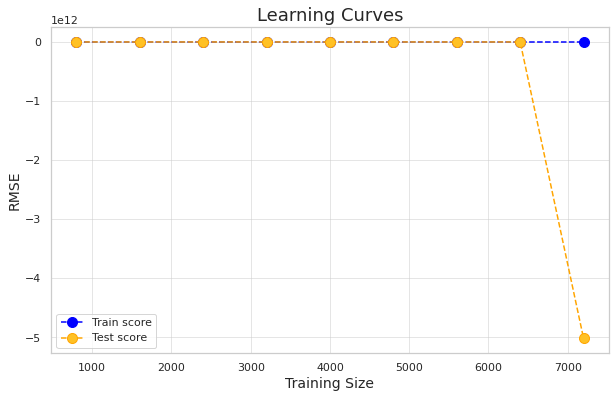

In [50]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Ridge linear Regression

In [51]:
%%time
# Instanciate model
model = Ridge()

# Hyperparameter search space
search_space = {
    'alpha': [1,10,100,1000],
    'tol': [0, 0.001,0.1,1],
    'solver': ['lsqr','auto']# auto, 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
}

# Instanciate GridSearchCV
ridge_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


ridge_rsearch.fit(X,y)
report_best_scores(ridge_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.886 (std: 0.870)
Parameters: {'alpha': 100, 'solver': 'lsqr', 'tol': 0}

CPU times: user 440 ms, sys: 284 ms, total: 724 ms
Wall time: 1 s


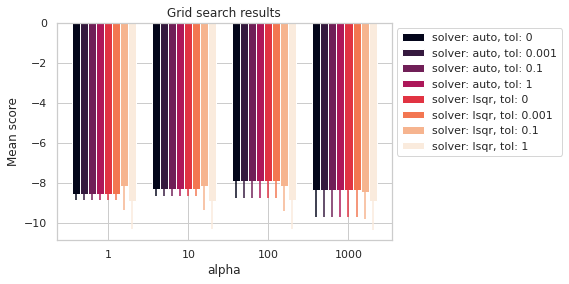

In [52]:
plot.grid_search(ridge_rsearch.cv_results_, change="alpha", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [53]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = ridge_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

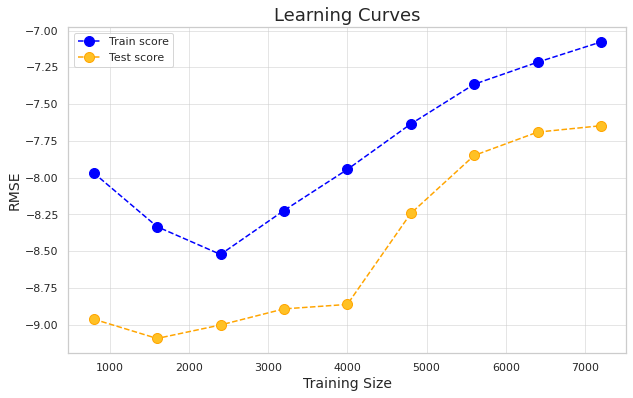

In [54]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Lasso linear Regression

In [55]:
%%time
# Instanciate model
model = Lasso()

# Hyperparameter search space
search_space = {
    'alpha': [0.001,0.01,0.1,1],
    'tol': [0.1,1,10,100],
    'selection': ['cyclic', 'random']
}

# Instanciate GridSearchCV
lasso_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


lasso_rsearch.fit(X,y)
report_best_scores(lasso_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.917 (std: 0.711)
Parameters: {'alpha': 0.01, 'selection': 'cyclic', 'tol': 1}

CPU times: user 402 ms, sys: 122 ms, total: 524 ms
Wall time: 858 ms


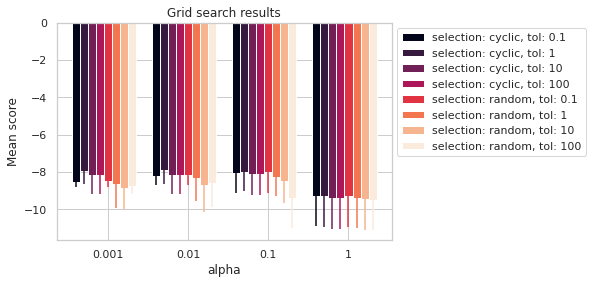

In [56]:
plot.grid_search(lasso_rsearch.cv_results_, change="alpha", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [57]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = lasso_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

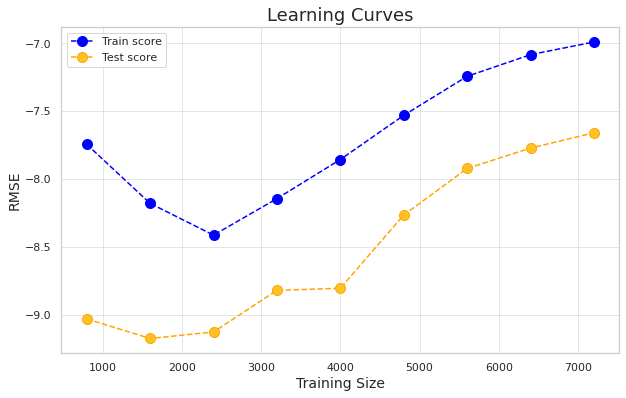

In [58]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## ElasticNet linear Regression

In [59]:
%%time
# Instanciate model
model = ElasticNet()

# Hyperparameter search space
search_space = {
    'alpha': [0.001,0.01,0.1,1],
    'tol': [1,10,100],
    'l1_ratio': [0,0.3,0.6,1],
    'selection': ['cyclic', 'random']
}

# Instanciate GridSearchCV
elastic_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


elastic_rsearch.fit(X,y)
report_best_scores(elastic_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.818 (std: 0.883)
Parameters: {'alpha': 0.01, 'l1_ratio': 0, 'selection': 'cyclic', 'tol': 1}

CPU times: user 633 ms, sys: 124 ms, total: 758 ms
Wall time: 2.04 s


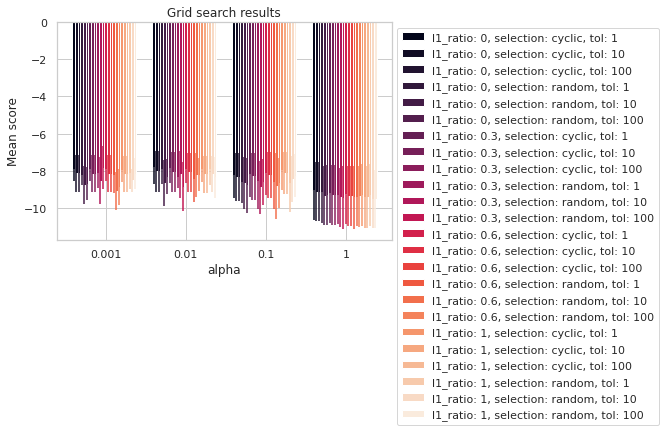

In [60]:
plot.grid_search(elastic_rsearch.cv_results_, change="alpha", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [61]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = elastic_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

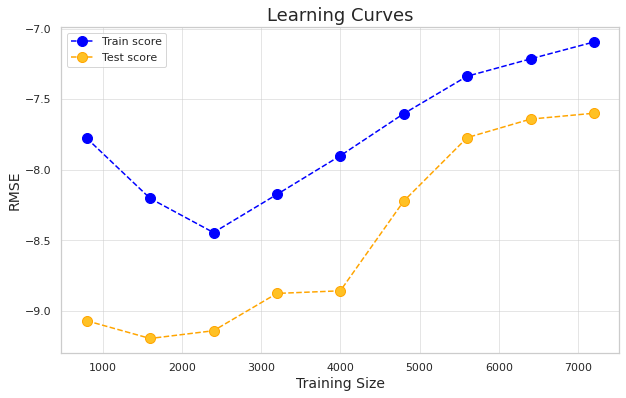

In [62]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Stochastic Gradient Descend

In [63]:
%%time
# Instanciate model
model = SGDRegressor()

# Hyperparameter search space
search_space = {
    'loss':['squared_error','epsilon_insensitive', 'squared_epsilon_insensitive'],#, 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'alpha': [0.0001, 0.001,0.01],
    'penalty': ['elasticnet'],#['l1','l2','elasticnet'],
    'tol': [10],#[1,10,100],
    'l1_ratio': [1],#[0,0.3,0.6,1],
    'epsilon': [1,10,100],
    'learning_rate': ['invscaling'],#,'constant','optimal','adaptive'],
    'eta0': [0.001,0.01,0.1], 
    'power_t': [0.25],
    'early_stopping': [True]
}

# Instanciate GridSearchCV
sgdr_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


sgdr_rsearch.fit(X,y)
report_best_scores(sgdr_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.714 (std: 1.097)
Parameters: {'alpha': 0.001, 'early_stopping': True, 'epsilon': 1, 'eta0': 0.01, 'l1_ratio': 1, 'learning_rate': 'invscaling', 'loss': 'squared_epsilon_insensitive', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 10}

CPU times: user 589 ms, sys: 356 ms, total: 946 ms
Wall time: 3.13 s


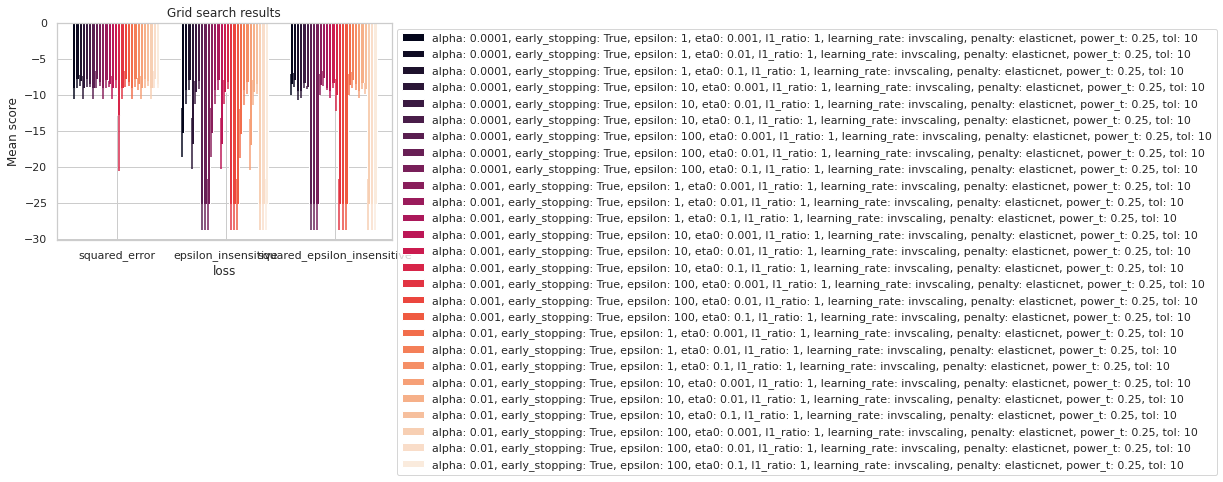

In [64]:
plot.grid_search(sgdr_rsearch.cv_results_, change="loss", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [65]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = sgdr_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

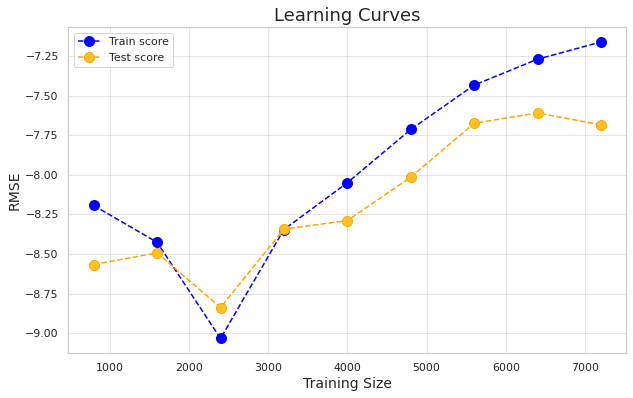

In [66]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## KNN Regressor

In [67]:
%%time
# Instanciate model
model = KNeighborsRegressor(n_jobs=-1)

# Hyperparameter search space
search_space = {
    'n_neighbors': range(20,50,1),
    'weights': ['distance'],#['uniform', 'distance'],
    'algorithm': ['brute'],#['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [2]#range(2,15,1)
}

# Instanciate GridSearchCV
knn_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


knn_rsearch.fit(X,y)
report_best_scores(knn_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -8.414 (std: 1.186)
Parameters: {'algorithm': 'brute', 'leaf_size': 2, 'n_neighbors': 22, 'weights': 'distance'}

CPU times: user 857 ms, sys: 69.6 ms, total: 927 ms
Wall time: 56.3 s


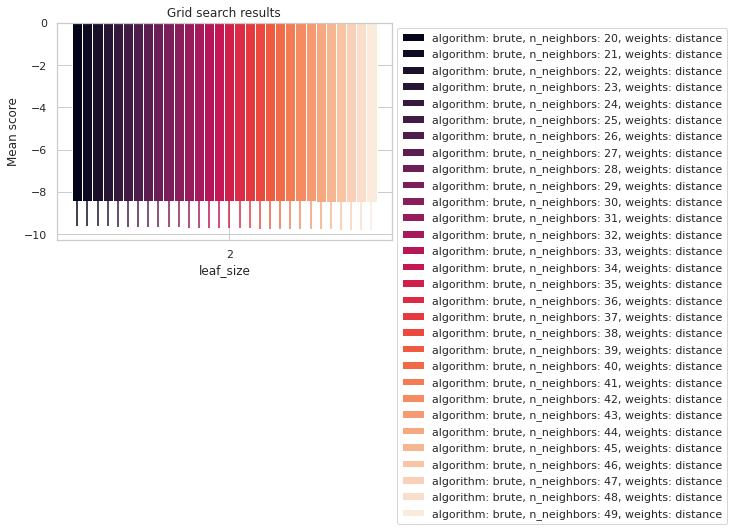

In [68]:
plot.grid_search(knn_rsearch.cv_results_, change="leaf_size", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [69]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = knn_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

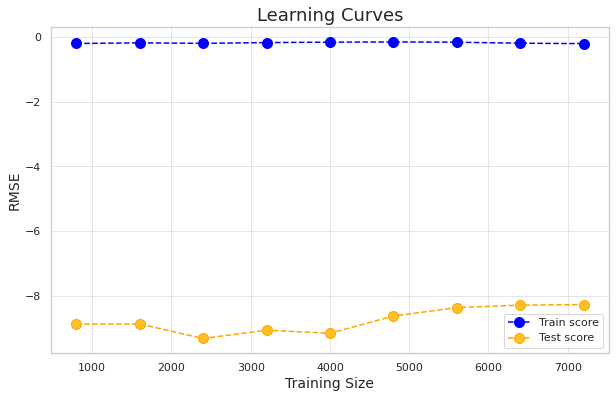

In [70]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Support Vector Machine

In [71]:
%%time
# Instanciate model
model = SVR()

# Hyperparameter search space
search_space = {
    'kernel': ['poly'],#['linear','poly','sigmoid', 'rbf'],
    'degree': range(2,5,1),
    'C': [10,100,1000],
    'tol': [0.001],#[0.001,0.01,0.1],
    'gamma': ['auto'],#[0,0.1,1,'scale','auto'],
    'coef0': [0],#[0,0.1,1],
    'epsilon': [1],#[0.1,1,10]
}

# Instanciate GridSearchCV
svm_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


svm_rsearch.fit(X,y)
report_best_scores(svm_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.806 (std: 0.990)
Parameters: {'C': 100, 'coef0': 0, 'degree': 2, 'epsilon': 1, 'gamma': 'auto', 'kernel': 'poly', 'tol': 0.001}

CPU times: user 2.96 s, sys: 53.6 ms, total: 3.01 s
Wall time: 55.4 s


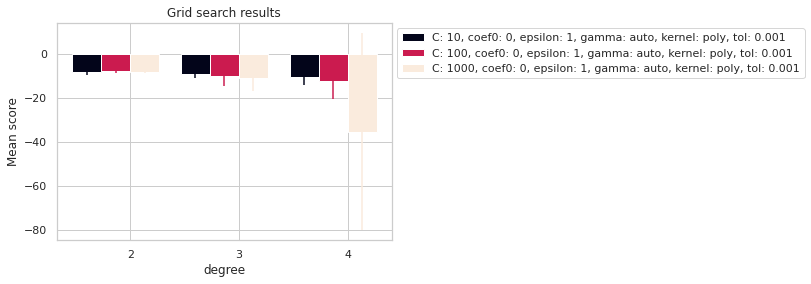

In [72]:
plot.grid_search(svm_rsearch.cv_results_, change="degree", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [73]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = svm_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

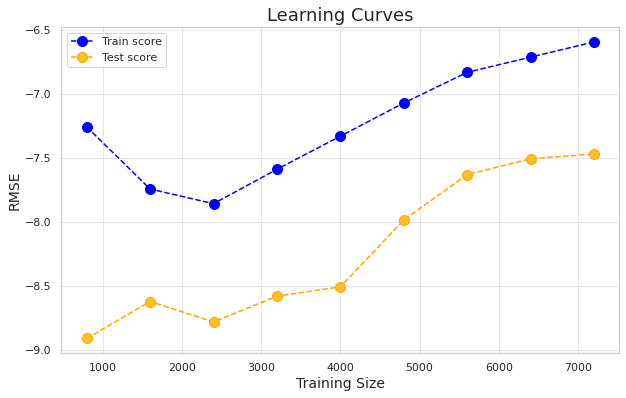

In [74]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Decision Tree Regressor

In [75]:
%%time
# Instanciate model
model = DecisionTreeRegressor()

# Hyperparameter search space
search_space = {
    'criterion': ['squared_error'],#['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best','random'],
    'max_depth': range(2,5,1),
    'min_samples_split': range(14,17,1),
    'min_samples_leaf': range(2,5,1),
    'min_weight_fraction_leaf': [0.0],#[0.0,0.1,0.2],
    'max_features': [0.8],#[0.6,0.7,0.8,0.9],
    'max_leaf_nodes': [4],#range(3,5,1), #int, default=None
    'min_impurity_decrease': [0.3],#[0.2,0.3,0.4,0.5],
    'ccp_alpha':[0.0],#[0.2,0.25,0.3,0.35],
}

# Instanciate GridSearchCV
tree_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


tree_rsearch.fit(X,y)
report_best_scores(tree_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -8.639 (std: 1.321)
Parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.8, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.3, 'min_samples_leaf': 3, 'min_samples_split': 16, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}

CPU times: user 503 ms, sys: 0 ns, total: 503 ms
Wall time: 2.37 s


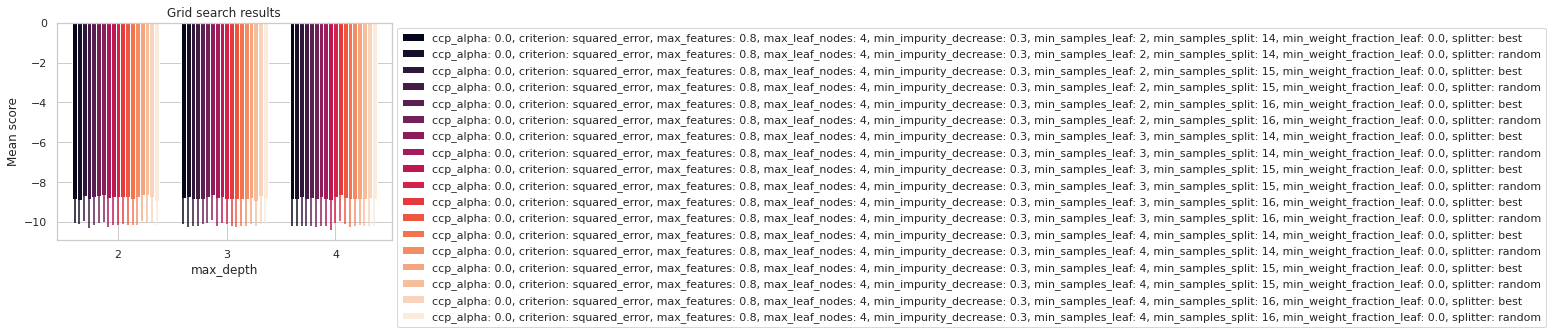

In [76]:
plot.grid_search(tree_rsearch.cv_results_, change="max_depth", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [77]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = tree_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

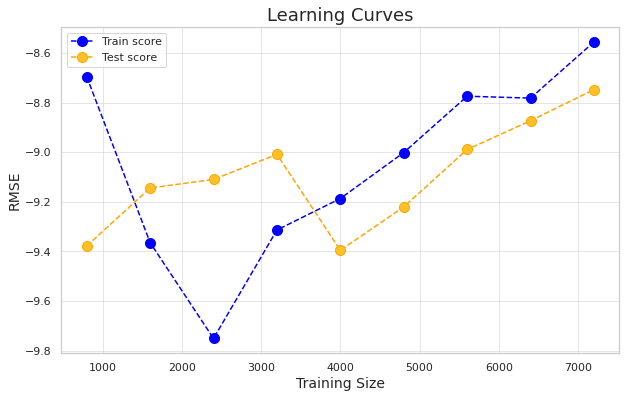

In [78]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Random Forest Regressor

In [79]:
%%time
# Instanciate model
model = RandomForestRegressor()

# Hyperparameter search space
search_space = {
    'n_jobs':[-1],
    'n_estimators': [100],#[100,200,500,1000],
    'criterion': ['squared_error'],#['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': range(2,5,1),
    'min_samples_split': range(3,6,1),
    'min_samples_leaf': range(2,4,1),
    'min_weight_fraction_leaf': [0.0],#[0.0,0.1,0.2],
    'max_features': [1.0],#[0.7,0.8,0.9,1.0],
    'max_leaf_nodes': [4],#range(3,5,1), #int, default=None
    'min_impurity_decrease': [0.4],#[0.3,0.4,0.5],
    'bootstrap':[False],#[True, False]
    'ccp_alpha':[0.0],
}

# Instanciate GridSearchCV
rand_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


rand_rsearch.fit(X,y)
report_best_scores(rand_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -8.738 (std: 1.418)
Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 2, 'max_features': 1.0, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.4, 'min_samples_leaf': 2, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1}

Model with rank: 1
Mean validation score: -8.738 (std: 1.418)
Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 2, 'max_features': 1.0, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.4, 'min_samples_leaf': 2, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1}

Model with rank: 1
Mean validation score: -8.738 (std: 1.418)
Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 2, 'max_features': 1.0, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.4, 'min_samples_leaf': 3, 'min_samples_split': 6, 'min_weight_fraction_leaf': 

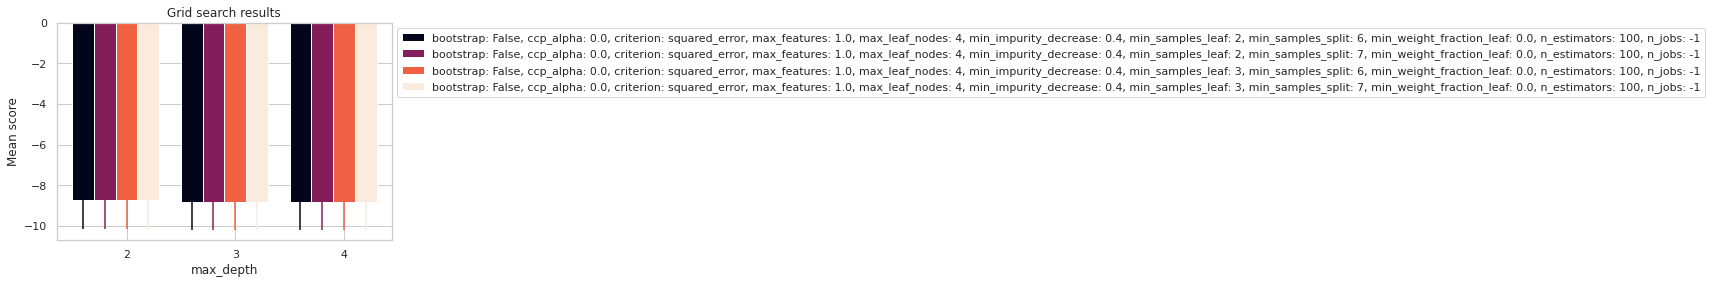

In [80]:
plot.grid_search(rand_rsearch.cv_results_, change="max_depth", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [81]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = rand_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

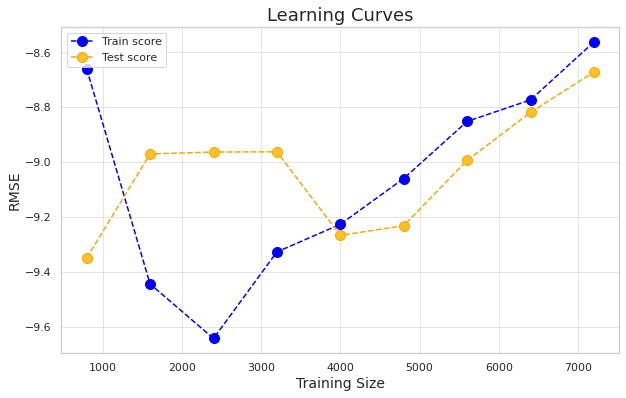

In [82]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Gradient Boosting Regressor

In [83]:
%%time
# Instanciate model
model = GradientBoostingRegressor()

# Hyperparameter search space
search_space = {
    'learning_rate': [0.1],#[0.001,0.01,0.1],
    'n_estimators': [100],#[100,200,500,1000],
    'loss': ['squared_error'],#['squared_error', 'absolute_error', 'huber', 'quantile'],
    'subsample':[0.66],#[0.33,0.66,1.0],
    'criterion': ['friedman_mse'],#['squared_error', 'friedman_mse'],
    'min_samples_split': [7],#range(6,8,1),
    'min_samples_leaf': [3],#range(2,4,1),
    'min_weight_fraction_leaf': [0.0],#[0.0,0.1,0.2],
    'max_depth': range(2,4,1),
    'min_impurity_decrease': [0.4],#[0.3,0.4,0.5],
    'max_features': [0.7,0.8,0.9,1.0],
    'max_leaf_nodes': [4],#range(3,5,1),
    'ccp_alpha':[0.3],#[0.25,0.3,0.35],
}

# Instanciate GridSearchCV
gradboos_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


gradboos_rsearch.fit(X,y)
report_best_scores(gradboos_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.932 (std: 1.040)
Parameters: {'ccp_alpha': 0.3, 'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 1.0, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.4, 'min_samples_leaf': 3, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'subsample': 0.66}

CPU times: user 1.16 s, sys: 18.9 ms, total: 1.18 s
Wall time: 8.23 s


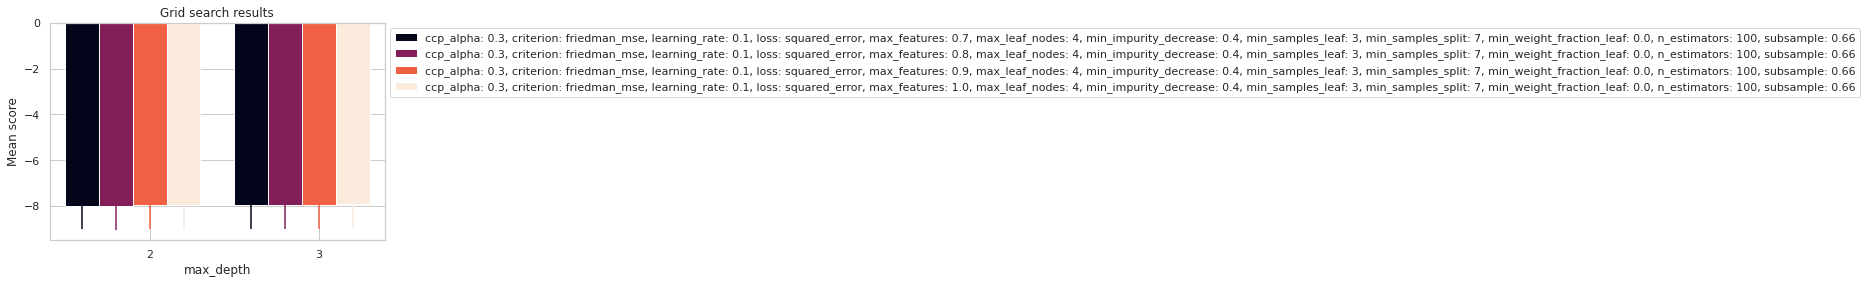

In [84]:
plot.grid_search(gradboos_rsearch.cv_results_, change="max_depth", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [85]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = gradboos_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

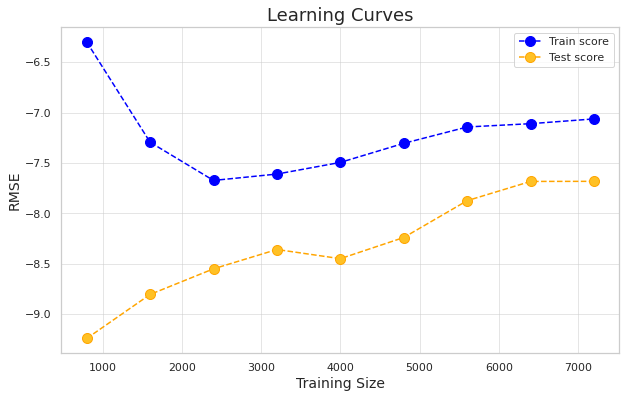

In [86]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Extreme Gradient Boosting (XGB) Regressor

In [87]:
%%time
# Instanciate model
model = XGBRegressor()

# Hyperparameter search space
search_space = {
    "colsample_bytree": [0.6,0.7,0.8],
#     "gamma": [0.3,0.4,0.5],
    "learning_rate": [0.1],#[0.1,0.01,0.001], # default 0.1 
    "max_depth": range(2,4,1), # default 3
    "n_estimators": range(100,150,10), # default 100
    "subsample": [0.2],#[0.1,0.2,0.3]
}

# Instanciate GridSearchCV
xgb_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


xgb_rsearch.fit(X,y)
report_best_scores(xgb_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.609 (std: 0.966)
Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 130, 'subsample': 0.2}

CPU times: user 3.25 s, sys: 0 ns, total: 3.25 s
Wall time: 27.8 s


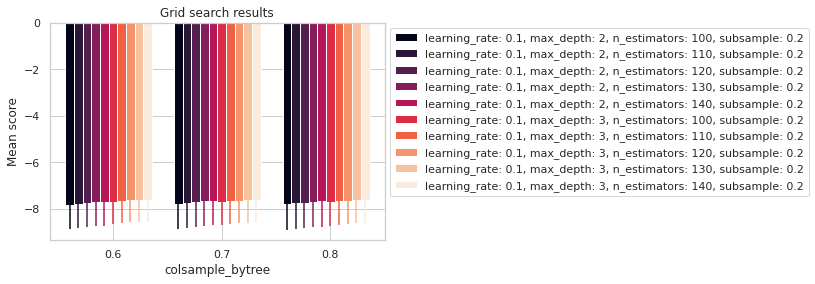

In [88]:
plot.grid_search(xgb_rsearch.cv_results_, change="colsample_bytree", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [89]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = xgb_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

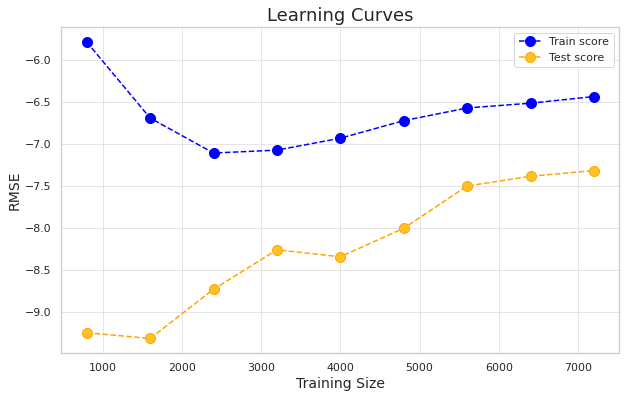

In [90]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

# Building model

In [91]:
X = df_analysed.drop(columns=['price_per_sqm_cold'])
X = df_analysed[important_features]
y = df_analysed['price_per_sqm_cold']

In [92]:
## After all this analysis, the linearRegression model seems to outperform all other models....
## Also, analysis of the learning curves indicate that the model training is not yet saturated by number of data points, so I'd use as many as possible for training


In [93]:
## Predicting the log of the prices instead of the prices directly might improve prediction slightly
# y = np.log2(df_analysed['price_per_sqm_cold'])

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.1, 
                                                    random_state = 0)

scores = pd.DataFrame(columns=['model','r2','explained_variance','MAE','MSE',#'MSLE',
                               'RMSE'])

model = None

for mod in [LinearRegression(n_jobs=-1),
            ridge_rsearch.best_estimator_,
            lasso_rsearch.best_estimator_,
            sgdr_rsearch.best_estimator_,
            knn_rsearch.best_estimator_,
            svm_rsearch.best_estimator_,
            tree_rsearch.best_estimator_,
            rand_rsearch.best_estimator_,
            gradboos_rsearch.best_estimator_,
            xgb_rsearch.best_estimator_,
             ]:
    
    mod.fit(X_train,y_train)
    
    mod_name = type(mod).__name__
    
    y_pred = mod.predict(X_test)

    explained_variance=metrics.explained_variance_score(y_test, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_test, y_pred) 
    mse=metrics.mean_squared_error(y_test, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_test, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_test, y_pred)
    mod_r2=metrics.r2_score(y_test, y_pred)
    
    
#     mod_r2 = mod.score(X_test, y_test)

    scores = pd.concat([scores, pd.DataFrame.from_dict({'model':[mod_name],
                                 'r2':[round(mod_r2,4)],
                                 'explained_variance':[round(explained_variance,4)],
                                 'MAE':[round(mean_absolute_error,4)],
                                 'MSE':[round(mse,4)],
#                                  'MSLE':[round(mean_squared_log_error,4)],
                                 'RMSE':[round(np.sqrt(mse),4)]   
                                })
                       ]).reset_index(drop=True)
    
    if model is None:
        model = mod
    if mod_r2> model.score(X_test, y_test):
        model = mod
    
scores.sort_values(by='r2', ascending=False)

,model,r2,explained_variance,MAE,MSE,RMSE
9,XGBRegressor,0.5313,0.5313,4.9712,43.5346,6.5981
5,SVR,0.5270,0.5289,4.9734,43.9310,6.6280
0,LinearRegression,0.5257,0.5262,5.0355,44.0508,6.6371
2,Lasso,0.5163,0.5166,5.0718,44.9240,6.7025
1,Ridge,0.4940,0.4943,5.1717,46.9927,6.8551
3,SGDRegressor,0.4916,0.4937,5.2319,47.2210,6.8718
8,GradientBoostingRegressor,0.4681,0.4687,5.3619,49.4009,7.0286
4,KNeighborsRegressor,0.3922,0.3926,5.7323,56.4501,7.5133
6,DecisionTreeRegressor,0.2589,0.2593,6.4530,68.8362,8.2968
7,RandomForestRegressor,0.2419,0.2422,6.5111,70.4107,8.3911


In [94]:
type(model).__name__

'XGBRegressor'

In [95]:
# Cross-validate Pipeline
cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()

0.47746958285662566

RMSE: 6.598073949801841
RMSE base model (mean value): 9.638485117703382


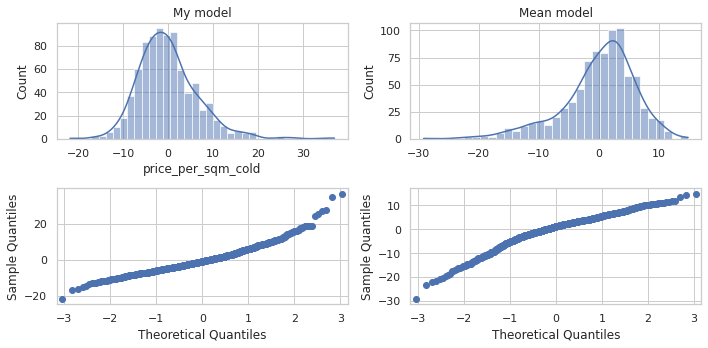

In [96]:
import statsmodels.api as sm

y_pred = model.predict(X_test)
y_base = [np.mean(y)]*len(y_pred)
y_true = y_test

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model (mean value): {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(y_pred)
residuals = y_true - y_pred
residuals_base = y_base - y_pred

# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
sns.histplot(residuals, kde=True, edgecolor='w', ax=ax1).set(title='My model')
sns.histplot(residuals_base, kde=True, edgecolor='w', ax=ax2).set(title='Mean model')

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(residuals, ax=ax3)
sm.qqplot(residuals_base, ax=ax4)
plt.tight_layout()
fig.show();

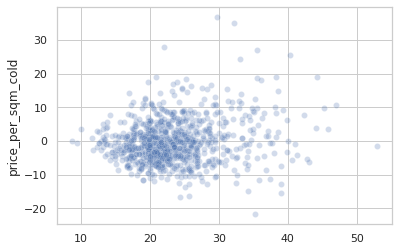

In [97]:
sns.scatterplot(x=y_pred, y=residuals,alpha=0.25);

# Simple linear model

In [ ]:
# Select data from a specified time period
df_OLS = pd.merge(ads_feat_df['published_on'], df_analysed, left_index=True, right_index=True)
# df_OLS = df_OLS[df_OLS['published_on'] <= '2022-08-01']
# df_OLS = df_OLS[df_OLS['published_on'] > '2022-08-08']
# df_OLS['price_per_sqm_cold'] = np.log2(df_OLS['price_per_sqm_cold'])

In [ ]:
print(df_OLS.shape)
df_OLS.describe()

In [ ]:
# OLS model
formula = 'price_per_sqm_cold' + ' ~ ' + ' + '.join(str(feat) for feat in important_features)# if feat not in features_OSM)

model = smf.ols(formula = formula, data=df_OLS).fit()
model.summary()

In [ ]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model.params[0:].plot(kind='barh');

In [ ]:
y_pred = model.predict(df_OLS)
y_base = [np.mean(df_OLS['price_per_sqm_cold'])]*len(y_pred)
y_true = df_OLS['price_per_sqm_cold']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_analysed)
residuals = y_true - y_pred 
residuals_base = y_true - y_base

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model.resid, ax=ax3)
plt.tight_layout()
fig.show();

In [ ]:
sns.scatterplot(x=model.predict(df_OLS), y=model.resid,alpha=0.1);

In [ ]:
df = return_significative_coef(model).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef[1:].plot(kind='barh');